**Simple DNN 2 - Binary classification, Hyperparameters, Callbacks**  
**Part 1 Binary classification problem**  
Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. The aim of this lab is to classify movie reviews into “positive” reviews and “negative” reviews, just based on the text content of the reviews.

**The IMDB dataset**  
We'll be working with the “IMDB dataset”, a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.
Please load the dataset from Keras (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [2]:
from tensorflow.keras.datasets import imdb

# The argument num_words=10000 means that we will only keep the top 10,000 most frequently occurring words 
# in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size.
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

2023-10-12 20:01:31.510383: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-12 20:01:31.510499: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-12 20:01:31.510648: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-12 20:01:31.775338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 20:01:33.231459: W tensorflow/compiler/

**Preparing the data**  
We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:
- We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape (samples, word_indices), then use as the first layer in our network a layer capable of handling such integer tensors (the Embedding layer, which we will cover in detail later in the book).
- We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as the first layer in our network a Dense layer, capable of handling floating-point vector data.

In [3]:
dimension = 10000

In [4]:
# Implementation of the second solution.
import numpy as np
 
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))  # Create an all-zero matrix of shape (len(sequences), dimension)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
 
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

**Network architecture**  
Based on the previous ex. please implement a deep network architecture shown in the following Figure:  
![network_architecture](images/lesson_2_network_architecture.png)

I propose the following architecture choice:
- Two intermediate layers with 16 hidden units each, and a third layer which will output the scalar prediction regarding the sentiment of the current review.
- The intermediate layers will use relu as their “activation function”, and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target “1”, i.e. how likely the review is to be positive).
- A relu (rectified linear unit) is a function meant to zero-out negative values, while a sigmoid “squashes” arbitrary values into the [0, 1] interval, thus outputting something that can be interpreted as a probability.


In [5]:
import tensorflow as tf
#TODO: Implement the architecture
layers = [
    tf.keras.layers.Dense(16, activation='relu', input_shape=(dimension,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
]

**Network training**  
Since we are facing a binary classification problem and the output of our network is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. It isn't the only viable choice: you could use, for instance, mean_squared_error. But crossentropy is usually the best choice when you are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the “distance” between probability distributions, or in our case, between the ground-truth distribution and our predictions.

To configure the model please use the following parameters:
- rmsprop optimizer
- binary_crossentropy loss function
- accuracy metric

In [6]:
#TODO: Compile the model
model = tf.keras.Sequential(layers)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

**Validation**  
In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a “validation set” by setting apart 10,000 samples from the original data (suggested split: 25000 train, 10000 validation, 15000 test). You can do it manually or use `train_test_split` from `sklearn` library:

In [7]:
import sklearn
from sklearn.model_selection import train_test_split

test_data_size = 15000
x_data_size = len(x_test)
print(x_data_size)
test_size = test_data_size/x_data_size

#TODO: please divide the dataset according to the description above
x_val, x_test, y_val, y_test = train_test_split(x_test,
                                                y_test,
                                                test_size=test_size,
                                                random_state=42)

# Print the size of the training, validation, and test sets
print("[TRAIN] Data size: %d, Label size: %d" % (len(x_train), len(y_train)))
print("[VALIDATION] Data size: %d, Label size: %d" % (len(x_val), len(y_val)))
print("[TEST] Data size: %d, Label size: %d" % (len(x_test), len(y_test)))

25000
[TRAIN] Data size: 25000, Label size: 25000
[VALIDATION] Data size: 10000, Label size: 10000
[TEST] Data size: 15000, Label size: 15000


Train the model with following parameters:
- x_train, y_train -remained
- epochs - 20
- batch_size - 512
- validation_data=(x_val, y_val)

In [8]:
#TODO: Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
49/49 [==============================] - 1s 20ms/step - loss: 0.4769 - accuracy: 0.8037 - val_loss: 0.3623 - val_accuracy: 0.8638
Epoch 2/20
49/49 [==============================] - 0s 10ms/step - loss: 0.2819 - accuracy: 0.9012 - val_loss: 0.2953 - val_accuracy: 0.8860
Epoch 3/20
49/49 [==============================] - 0s 10ms/step - loss: 0.2185 - accuracy: 0.9218 - val_loss: 0.2885 - val_accuracy: 0.8858
Epoch 4/20
49/49 [==============================] - 1s 12ms/step - loss: 0.1847 - accuracy: 0.9345 - val_loss: 0.2935 - val_accuracy: 0.8844
Epoch 5/20
49/49 [==============================] - 1s 11ms/step - loss: 0.1599 - accuracy: 0.9452 - val_loss: 0.3151 - val_accuracy: 0.8777
Epoch 6/20
49/49 [==============================] - 0s 10ms/step - loss: 0.1422 - accuracy: 0.9510 - val_loss: 0.3307 - val_accuracy: 0.8765
Epoch 7/20
49/49 [==============================] - 1s 10ms/step - loss: 0.1294 - accuracy: 0.9546 - val_loss: 0.3484 - val_accuracy: 0.8740
Epoch 8/20
49

The network should achieve acc: 0.9998 and val_acc: 0.8683.

The history = model.fit() returns a History object. This object has a member history, which is a dictionary containing data about everything that happened during training.  
Let's take a look at it:

In [9]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Please use Matplotlib to plot the training and validation loss side by side, as well as the training and validation accuracy.

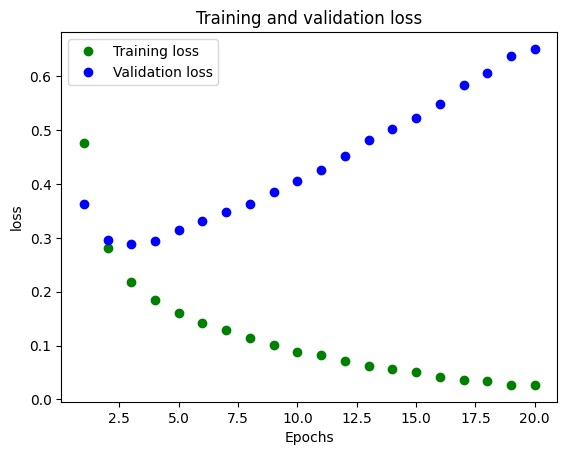

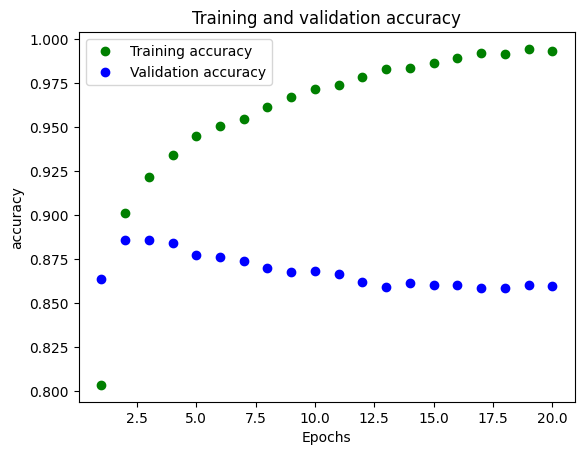

In [10]:
#TODO: plot
import matplotlib.pyplot as plt

def plot_metric(history_dict, metric):
    plt.clf()  # clear figure
    loss_values = history_dict[metric]
    val_loss_values = history_dict[f'val_{metric}']
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'go', label=f'Training {metric}')
    plt.plot(epochs, val_loss_values, 'bo', label=f'Validation {metric}')
    plt.title(f'Training and validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_metric(history_dict, 'loss')
plot_metric(history_dict, 'accuracy')

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. In precise terms, what you are seeing is “overfitting”: after the second epoch, we are over-optimizing on the training data, and we ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.  
Please check how that model performs on the test set too!!

In [15]:
#TODO: evaluate the results on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

469/469 [==============================] - 1s 2ms/step - loss: 0.6118 - accuracy: 0.8587
Test accuracy: 0.8587333559989929
Test loss: 0.6118165850639343
